# Cell 1 — Title & Introduction (Markdown)

# Time-Series Data Clustering with DTW (using tslearn)

In this notebook, we:

- Generate a small synthetic multivariate time-series dataset (multiple sequences, each a time series).  
- Use **tslearn** — a specialized time-series ML library — to cluster the time series using **DTW (Dynamic Time Warping)** distance. :contentReference[oaicite:1]{index=1}  
- Visualize the cluster assignments and show representative “centroids” of each cluster (as DTW barycenters).  
- Compare with naive clustering (e.g. flattening time-series into vectors + k-means) to highlight why time-series-aware clustering is better.  


# Cell 2 — Install & Imports

In [1]:
!pip install -q tslearn matplotlib numpy --quiet

import numpy as np
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.7/372.7 kB 5.7 MB/s eta 0:00:00


# Cell 3 — Generate Synthetic Time-Series Dataset

Here we build, say, 50 time series, each of length 100, belonging to 3 “underlying cluster shapes”.

Dataset shape: (60, 100, 1)


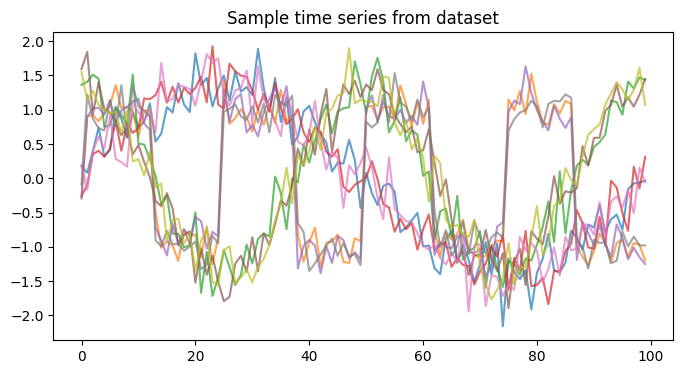

In [2]:
np.random.seed(42)

n_series = 60
series_length = 100
clusters = 3

# create base “prototype” signals
t = np.linspace(0, 1, series_length)

prototypes = [
    np.sin(2 * np.pi * t),            # sine wave
    np.sign(np.sin(8 * np.pi * t)),   # square-ish wave
    np.cos(4 * np.pi * t)             # cosine wave
]

# generate noisy variants around prototypes
X = np.zeros((n_series, series_length))
for i in range(n_series):
    prot = prototypes[i % clusters]
    noise = np.random.normal(scale=0.2, size=series_length)
    X[i] = prot + noise

# scale time series (tslearn expects 3D: (n_ts, sz, dims))
X = X[..., np.newaxis]
scaler = TimeSeriesScalerMeanVariance()
X_scaled = scaler.fit_transform(X)

print("Dataset shape:", X_scaled.shape)  # (n_series, series_length, 1)

# quick plot a few series
plt.figure(figsize=(8,4))
for i in range(9):
    plt.plot(X_scaled[i].ravel(), alpha=0.7)
plt.title("Sample time series from dataset")
plt.show()


# Cell 4 — Time-Series K-Means with DTW

In [3]:
k = clusters  # we know we generated 3 clusters

model = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=10, random_state=42)
labels = model.fit_predict(X_scaled)

print("Cluster counts:", np.bincount(labels))


Cluster counts: [20 20 20]


# Cell 5 — Visualize Clusters + Cluster Centroids

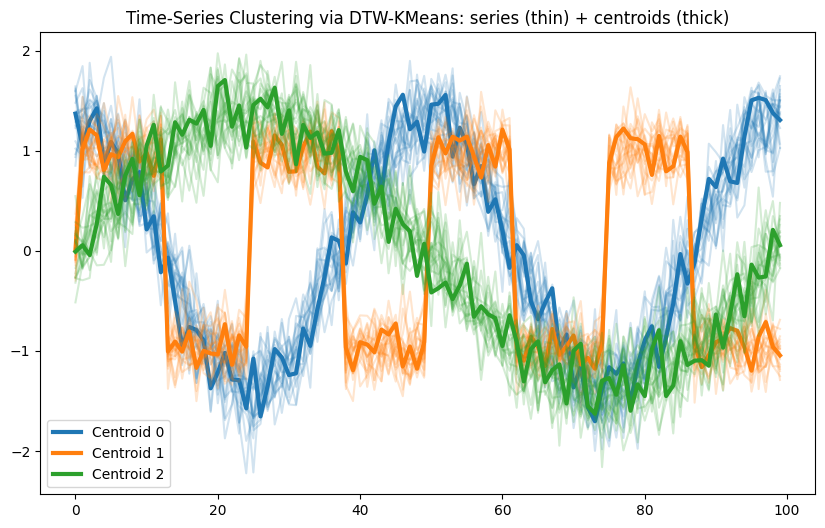

In [4]:
plt.figure(figsize=(10, 6))
for cluster_id in range(k):
    idx = labels == cluster_id
    for x in X_scaled[idx]:
        plt.plot(x.ravel(), color=f"C{cluster_id}", alpha=0.2)
    # plot centroid
    centroid = model.cluster_centers_[cluster_id].ravel()
    plt.plot(centroid, color=f"C{cluster_id}", label=f"Centroid {cluster_id}", linewidth=3)

plt.title("Time-Series Clustering via DTW-KMeans: series (thin) + centroids (thick)")
plt.legend()
plt.show()


# Cell 6 — Compare with Naive Clustering (Flatten + KMeans)

Naive KMeans cluster counts: [20 20 20]


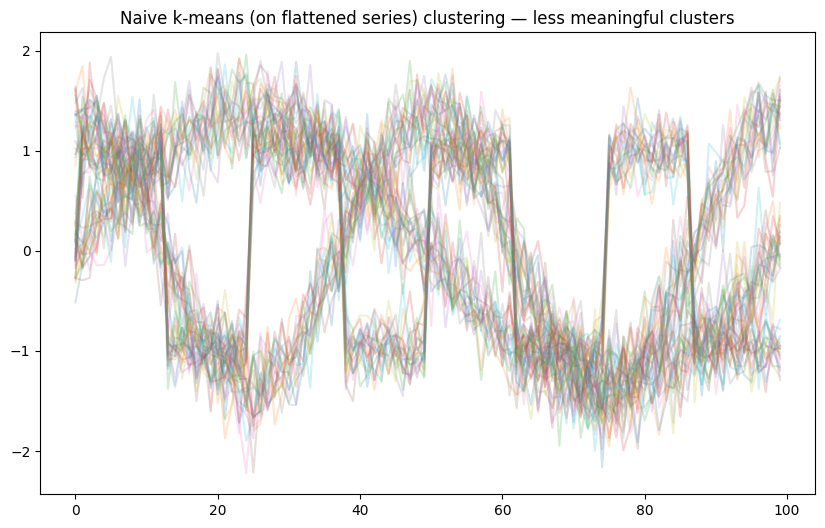

In [5]:
from sklearn.cluster import KMeans

# flatten time-series to feature vectors
X_flat = X_scaled.reshape((n_series, series_length))
k2 = KMeans(n_clusters=k, random_state=42, n_init="auto").fit_predict(X_flat)
print("Naive KMeans cluster counts:", np.bincount(k2))

# Visualize naive clusters
plt.figure(figsize=(10, 6))
for cluster_id in range(k):
    idx = k2 == cluster_id
    for x in X_scaled[idx]:
        plt.plot(x.ravel(), alpha=0.2)
plt.title("Naive k-means (on flattened series) clustering — less meaningful clusters")
plt.show()


# Cell 7 — Summary & Observations (Markdown)

## Summary & Takeaways

- We generated synthetic time-series data belonging to 3 underlying “shapes” (sine, cosine, square-like).  
- Using **tslearn + DTW-aware KMeans**, we clustered the time series and recovered meaningful groups.  :contentReference[oaicite:2]{index=2}  
- The cluster “centroids” reflect typical waveform shapes per cluster — useful for pattern discovery.  
- As a contrast, naive clustering on flattened series ignores temporal alignment and often mixes series of different shapes.  
- Conclusion: For time-series data, using time-aware metrics (like DTW) + specialized libraries yields far better clustering than treating series as flat vectors.
